# Phase 2.2 — Named Entity Recognition (NER)
**วิชา:** Introduction to Natural Language Processing  
**เป้าหมาย:** ใช้ spaCy Pre-trained model สกัด Entity (ชื่อคน, องค์กร, สถานที่) และทำสถิติเบื้องต้น

## 0. ติดตั้ง Dependencies
รันเซลล์นี้ครั้งแรกเท่านั้น

In [39]:
# # ติดตั้ง spaCy และ model ภาษาอังกฤษ
# !pip install spacy
# !python -m spacy download en_core_web_sm

# # ติดตั้ง library สำหรับ Visualization
# !pip install matplotlib seaborn wordcloud

## 1. Import Libraries

In [40]:
import pandas as pd
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# ตั้งค่า Style ของกราฟ
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 11
sns.set_theme(style='whitegrid')

print('✅ Import เสร็จแล้ว')

✅ Import เสร็จแล้ว


## 2. โหลด spaCy Model และข้อมูล

In [ ]:
# โหลด spaCy English model
# en_core_web_sm = small model (เร็ว, ขนาดเล็ก, เพียงพอสำหรับ NER ทั่วไป)
nlp = spacy.load('en_core_web_sm')

# โหลดข้อมูล — ใช้ 'Sentence' (ต้นฉบับ) ไม่ใช่ cleaned text
# เพราะ spaCy ต้องการ context ครบเพื่อจับ Entity ได้แม่นยำ
df = pd.read_csv('clean_text_(Web_Scraping).csv')

print(f'✅ โหลด Model: en_core_web_sm')
print(f'✅ จำนวนข้อมูล: {len(df):,} แถว')
print(f'✅ คอลัมน์: {df.columns.tolist()}')

✅ โหลด Model: en_core_web_sm
✅ จำนวนข้อมูล: 856 แถว
✅ คอลัมน์: ['Sentence']


## 3. ทดสอบ NER บนตัวอย่างก่อน

In [42]:
# ทดสอบกับประโยคตัวอย่างเพื่อดูว่า spaCy ทำงานถูกต้อง
sample_text = df['Sentence'].iloc[0]
print(f'[ข้อความ] {sample_text}\n')

doc = nlp(sample_text)

print(f'{"Entity":<35} {"Label":<12} {"คำอธิบาย"}')
print('-' * 70)
for ent in doc.ents:
    print(f'{ent.text:<35} {ent.label_:<12} {spacy.explain(ent.label_)}')

[ข้อความ] Could Intuitive Surgical Be the One Medtech Stock to Hold Through Any Market Crash?. This stock has climbed in the triple digits in recent years.

Entity                              Label        คำอธิบาย
----------------------------------------------------------------------
One                                 CARDINAL     Numerals that do not fall under another type
recent years                        DATE         Absolute or relative dates or periods


## 4. รัน NER บนข้อมูลทั้งหมด

> **หมายเหตุ:** ใช้ `nlp.pipe()` แทน `.apply()` เพราะเร็วกว่ามาก (Batch Processing)

In [43]:
# Entity Labels ที่สนใจสำหรับ Financial News Domain
TARGET_LABELS = {
    'PERSON': 'ชื่อคน',
    'ORG': 'องค์กร / บริษัท',
    'GPE': 'ประเทศ / เมือง / รัฐ',
    'LOC': 'สถานที่ทางภูมิศาสตร์',
    'MONEY': 'มูลค่าเงิน',
    'PRODUCT': 'ชื่อผลิตภัณฑ์',
    'EVENT': 'ชื่อเหตุการณ์'
}

# เก็บผล Entity ทั้งหมด
all_entities = []   # [(text, label), ...]
entity_per_row = [] # เก็บ list ของ entity ต่อแถว สำหรับใส่กลับใน df

print('กำลังรัน NER...')

# nlp.pipe() ประมวลผลแบบ Batch เร็วกว่าลูปธรรมดา ~3-5x
for doc in nlp.pipe(df['Sentence'], batch_size=256):
    row_entities = []
    for ent in doc.ents:
        if ent.label_ in TARGET_LABELS:
            cleaned_ent = ent.text.strip()
            all_entities.append((cleaned_ent, ent.label_))
            row_entities.append({'text': cleaned_ent, 'label': ent.label_})
    entity_per_row.append(row_entities)

df['entities'] = entity_per_row

# สร้าง DataFrame ของ Entity ทั้งหมด
ent_df = pd.DataFrame(all_entities, columns=['entity', 'label'])

print(f'✅ NER เสร็จแล้ว')
print(f'   - จำนวน Entity ที่พบทั้งหมด: {len(ent_df):,} รายการ')
print(f'   - Entity ไม่ซ้ำ: {ent_df["entity"].nunique():,} รายการ')

กำลังรัน NER...
✅ NER เสร็จแล้ว
   - จำนวน Entity ที่พบทั้งหมด: 3,837 รายการ
   - Entity ไม่ซ้ำ: 1,754 รายการ


## 5. สถิติภาพรวม — Entity แต่ละประเภทมีจำนวนเท่าไหร่

📊 สถิติจำนวน Entity แต่ละประเภท:


,Label,Count,ความหมาย
0,ORG,1763,องค์กร / บริษัท
1,GPE,905,ประเทศ / เมือง / รัฐ
2,PERSON,888,ชื่อคน
3,MONEY,140,มูลค่าเงิน
4,LOC,64,สถานที่ทางภูมิศาสตร์
5,PRODUCT,58,ชื่อผลิตภัณฑ์
6,EVENT,19,ชื่อเหตุการณ์


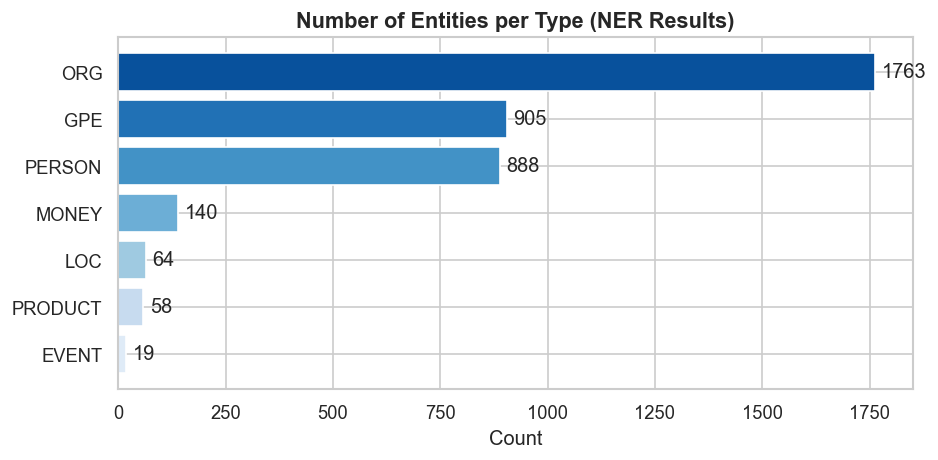

💾 Plot saved: ner_label_distribution.png


In [44]:
# นับจำนวน Entity แต่ละ Label
label_counts = ent_df['label'].value_counts().reset_index()
label_counts.columns = ['Label', 'Count']
label_counts['ความหมาย'] = label_counts['Label'].map(TARGET_LABELS)

print('📊 สถิติจำนวน Entity แต่ละประเภท:')
print('=' * 45)
display(label_counts)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
colors = sns.color_palette('Blues_r', len(label_counts))
bars = ax.barh(label_counts['Label'], label_counts['Count'], color=colors)
ax.bar_label(bars, fmt='%d', padding=4)
ax.set_xlabel('Count')
ax.set_title('Number of Entities per Type (NER Results)', fontsize=13, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('ner_label_distribution.png', bbox_inches='tight')
plt.show()
print('💾 Plot saved: ner_label_distribution.png')

## 6. Top 15 องค์กร (ORG) ที่ถูกพูดถึงมากที่สุด

🏢 Top 15 องค์กรที่ถูกพูดถึงมากที่สุด:


Rank,Organization,Count
1,ai,63
2,cnbc,45
3,apple,33
4,fed,32
5,trump,31
6,microsoft,24
7,meta,22
8,goldman sachs,21
9,amazon,19
10,bank of america,18


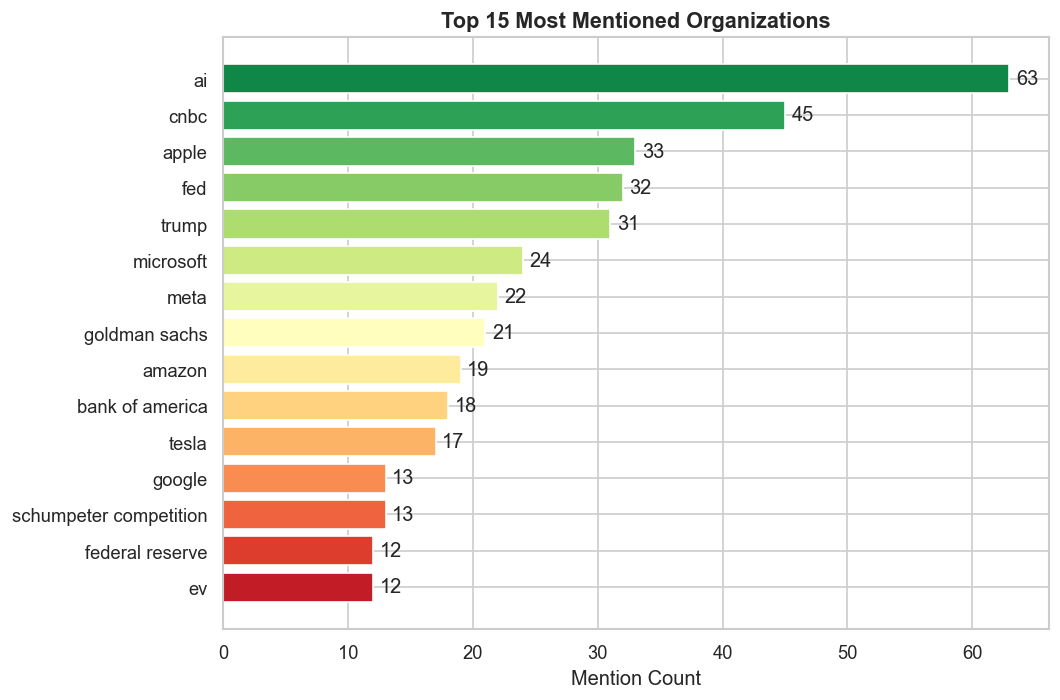

💾 Plot saved: ner_top_orgs.png


In [53]:
# กรองเฉพาะ ORG
org_df = ent_df[ent_df['label'] == 'ORG'].copy()

# Normalize: lowercase เพื่อรวม Apple Inc. กับ apple inc เข้าด้วยกัน
org_df['entity_norm'] = org_df['entity'].str.lower().str.strip()

top_orgs = org_df['entity_norm'].value_counts().head(15).reset_index()
top_orgs.columns = ['Organization', 'Count']
top_orgs = top_orgs.rename_axis('Rank').reset_index()  # สร้าง column Rank
top_orgs['Rank'] = top_orgs['Rank'] + 1  # เริ่มจาก 1

print('🏢 Top 15 องค์กรที่ถูกพูดถึงมากที่สุด:')
print('=' * 40)
display(top_orgs.style.hide(axis="index"))

# Plot
fig, ax = plt.subplots(figsize=(9, 6))
palette = sns.color_palette('RdYlGn_r', len(top_orgs))
bars = ax.barh(top_orgs['Organization'], top_orgs['Count'], color=palette)
ax.bar_label(bars, fmt='%d', padding=4)
ax.set_xlabel('Mention Count')
ax.set_title('Top 15 Most Mentioned Organizations', fontsize=13, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('ner_top_orgs.png', bbox_inches='tight')
plt.show()
print('💾 Plot saved: ner_top_orgs.png')

## 7. Top 15 บุคคล (PERSON) ที่ถูกกล่าวถึงมากที่สุด

👤 Top 15 บุคคลที่ถูกกล่าวถึงมากที่สุด:


Rank,Person,Count
1,donald trump,49
2,trump,27
3,lseg,21
4,bitcoin,13
5,warren buffett,13
6,berkshire hathaway,11
7,mark zuckerberg,10
8,zuckerberg,10
9,kevin warsh,8
10,don,8


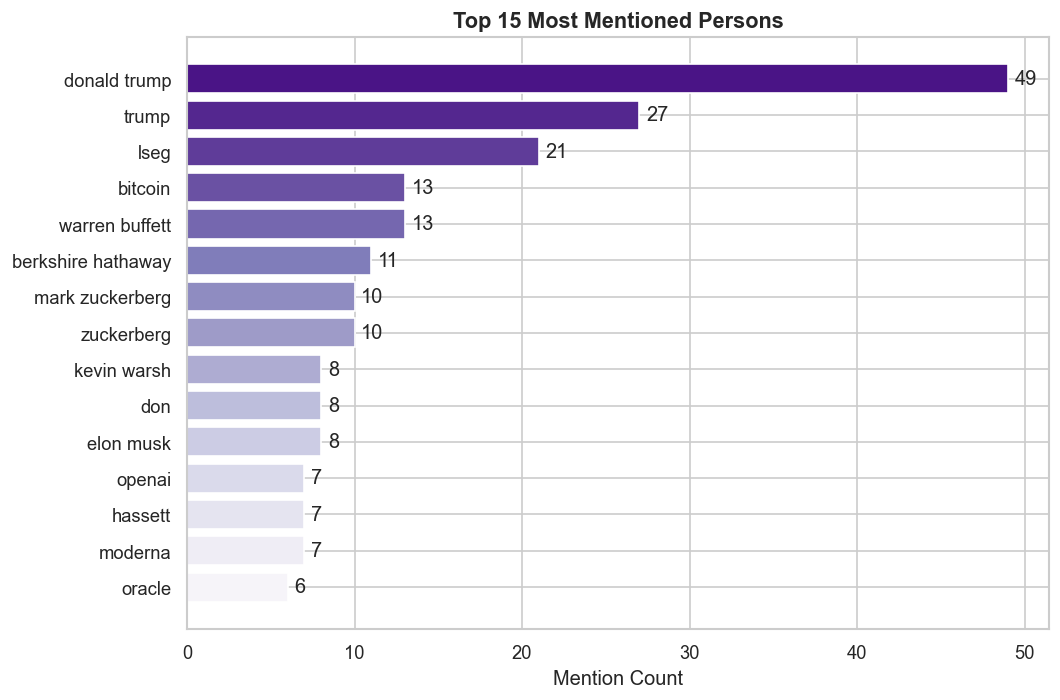

💾 Plot saved: ner_top_persons.png


In [54]:
# กรองเฉพาะ PERSON
person_df = ent_df[ent_df['label'] == 'PERSON'].copy()

# Normalize: lowercase
person_df['entity_norm'] = person_df['entity'].str.lower().str.strip()

# นับและจัดอันดับ
top_persons = person_df['entity_norm'].value_counts().head(15).reset_index()
top_persons.columns = ['Person', 'Count']

# 👇 เพิ่ม column Rank (1-15) ไว้คอลัมน์แรก
top_persons.insert(0, 'Rank', range(1, 16))

print('👤 Top 15 บุคคลที่ถูกกล่าวถึงมากที่สุด:')
print('=' * 40)

# 👇 แสดงผลโดยซ่อน index ด้านซ้ายสุด
display(top_persons.style.hide(axis="index"))

# Plot
fig, ax = plt.subplots(figsize=(9, 6))
palette = sns.color_palette('Purples_r', len(top_persons))
bars = ax.barh(top_persons['Person'], top_persons['Count'], color=palette)
ax.bar_label(bars, fmt='%d', padding=4)
ax.set_xlabel('Mention Count')
ax.set_title('Top 15 Most Mentioned Persons', fontsize=13, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('ner_top_persons.png', bbox_inches='tight')
plt.show()
print('💾 Plot saved: ner_top_persons.png')

## 8. Top 15 ประเทศ / สถานที่ (GPE + LOC) ที่พบมากที่สุด

🌍 Top 15 สถานที่ที่พบมากที่สุด (GPE + LOC):


Rank,Location,Count
1,ai,127
2,u.s.,112
3,china,93
4,america,62
5,us,47
6,iran,39
7,india,25
8,nvidia,19
9,europe,17
10,u.k.,15


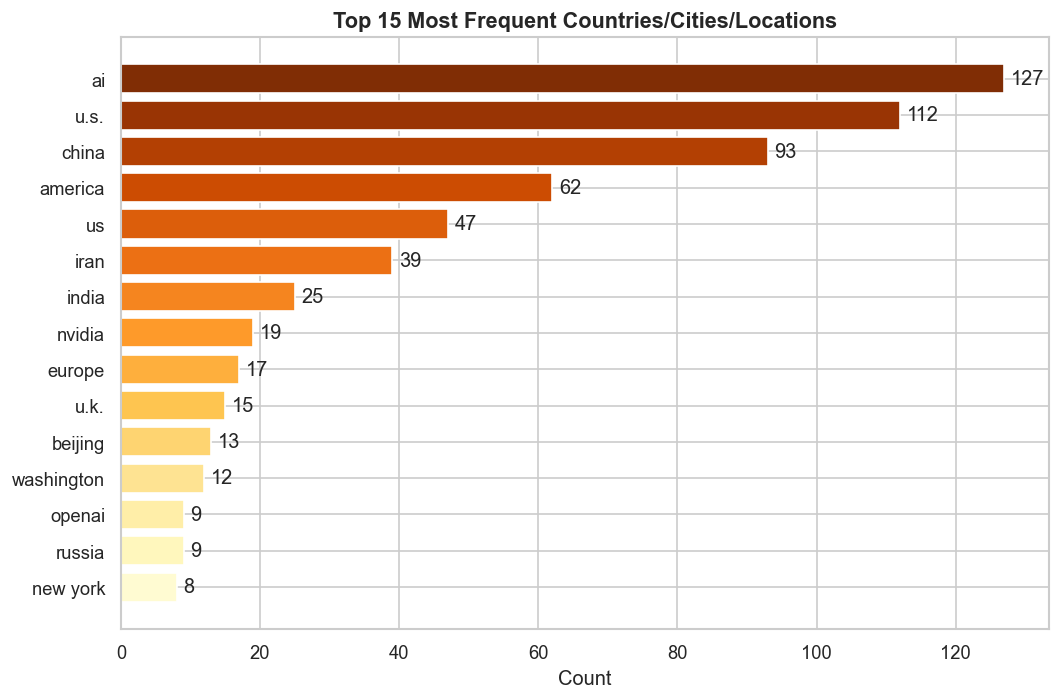

💾 Plot saved: ner_top_locations.png


In [55]:
# กรองเฉพาะ GPE และ LOC
location_df = ent_df[ent_df['label'].isin(['GPE', 'LOC'])].copy()

# Normalize: lowercase
location_df['entity_norm'] = location_df['entity'].str.lower().str.strip()

# นับและจัดอันดับ
top_locations = location_df['entity_norm'].value_counts().head(15).reset_index()
top_locations.columns = ['Location', 'Count']

# 👇 เพิ่ม column Rank (1-15) ไว้คอลัมน์แรก
top_locations.insert(0, 'Rank', range(1, 16))

print('🌍 Top 15 สถานที่ที่พบมากที่สุด (GPE + LOC):')
print('=' * 40)

# 👇 แสดงผลโดยซ่อน index ด้านซ้ายสุด
display(top_locations.style.hide(axis="index"))

# Plot
fig, ax = plt.subplots(figsize=(9, 6))
palette = sns.color_palette('YlOrBr_r', len(top_locations))
bars = ax.barh(top_locations['Location'], top_locations['Count'], color=palette)
ax.bar_label(bars, fmt='%d', padding=4)
ax.set_xlabel('Count')
ax.set_title('Top 15 Most Frequent Countries/Cities/Locations', fontsize=13, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('ner_top_locations.png', bbox_inches='tight')
plt.show()
print('💾 Plot saved: ner_top_locations.png')

## 9. Word Cloud — Entity ทั้งหมด

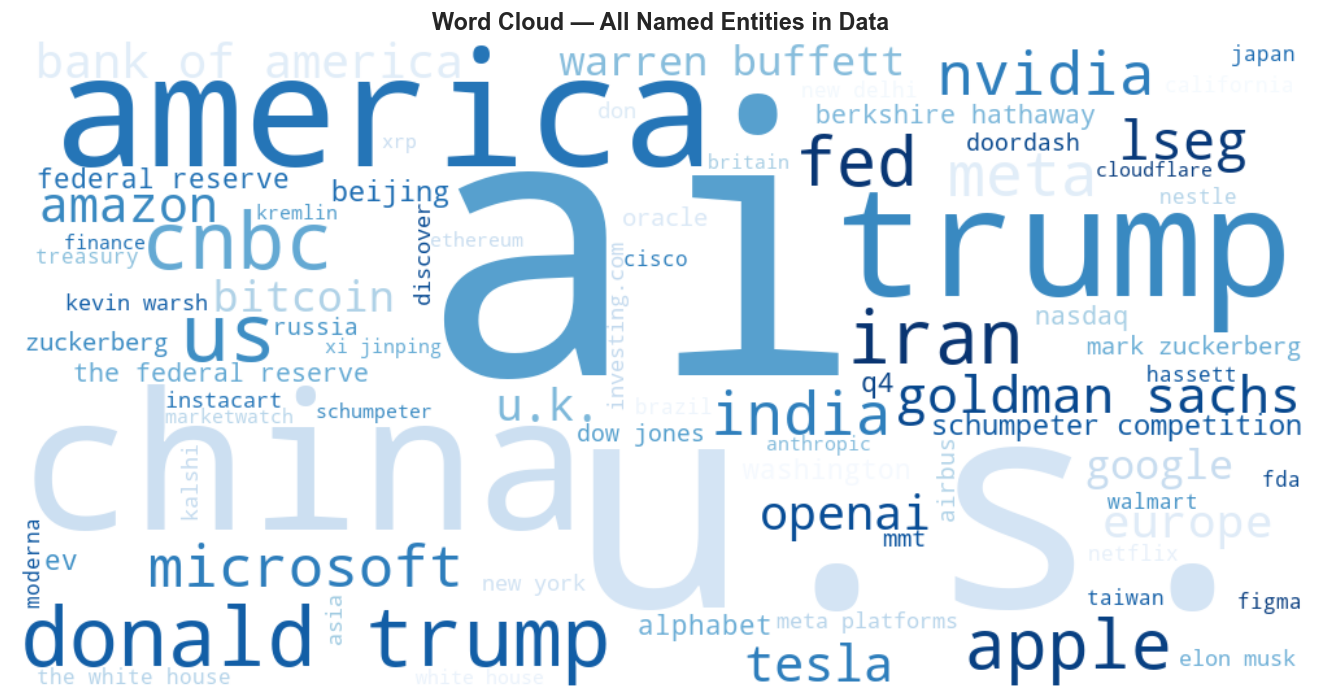

💾 Plot saved: ner_wordcloud.png


In [48]:
# สร้าง Word Cloud จาก Entity ทั้งหมด
entity_freq = ent_df['entity'].str.lower().value_counts().to_dict()

wc = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    colormap='Blues',
    max_words=80,
    min_font_size=10
).generate_from_frequencies(entity_freq)

fig, ax = plt.subplots(figsize=(13, 6))
ax.imshow(wc, interpolation='bilinear')
ax.axis('off')
ax.set_title('Word Cloud — All Named Entities in Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('ner_wordcloud.png', bbox_inches='tight')
plt.show()
print('💾 Plot saved: ner_wordcloud.png')

## 10. สรุปภาพรวม (Summary Dashboard)

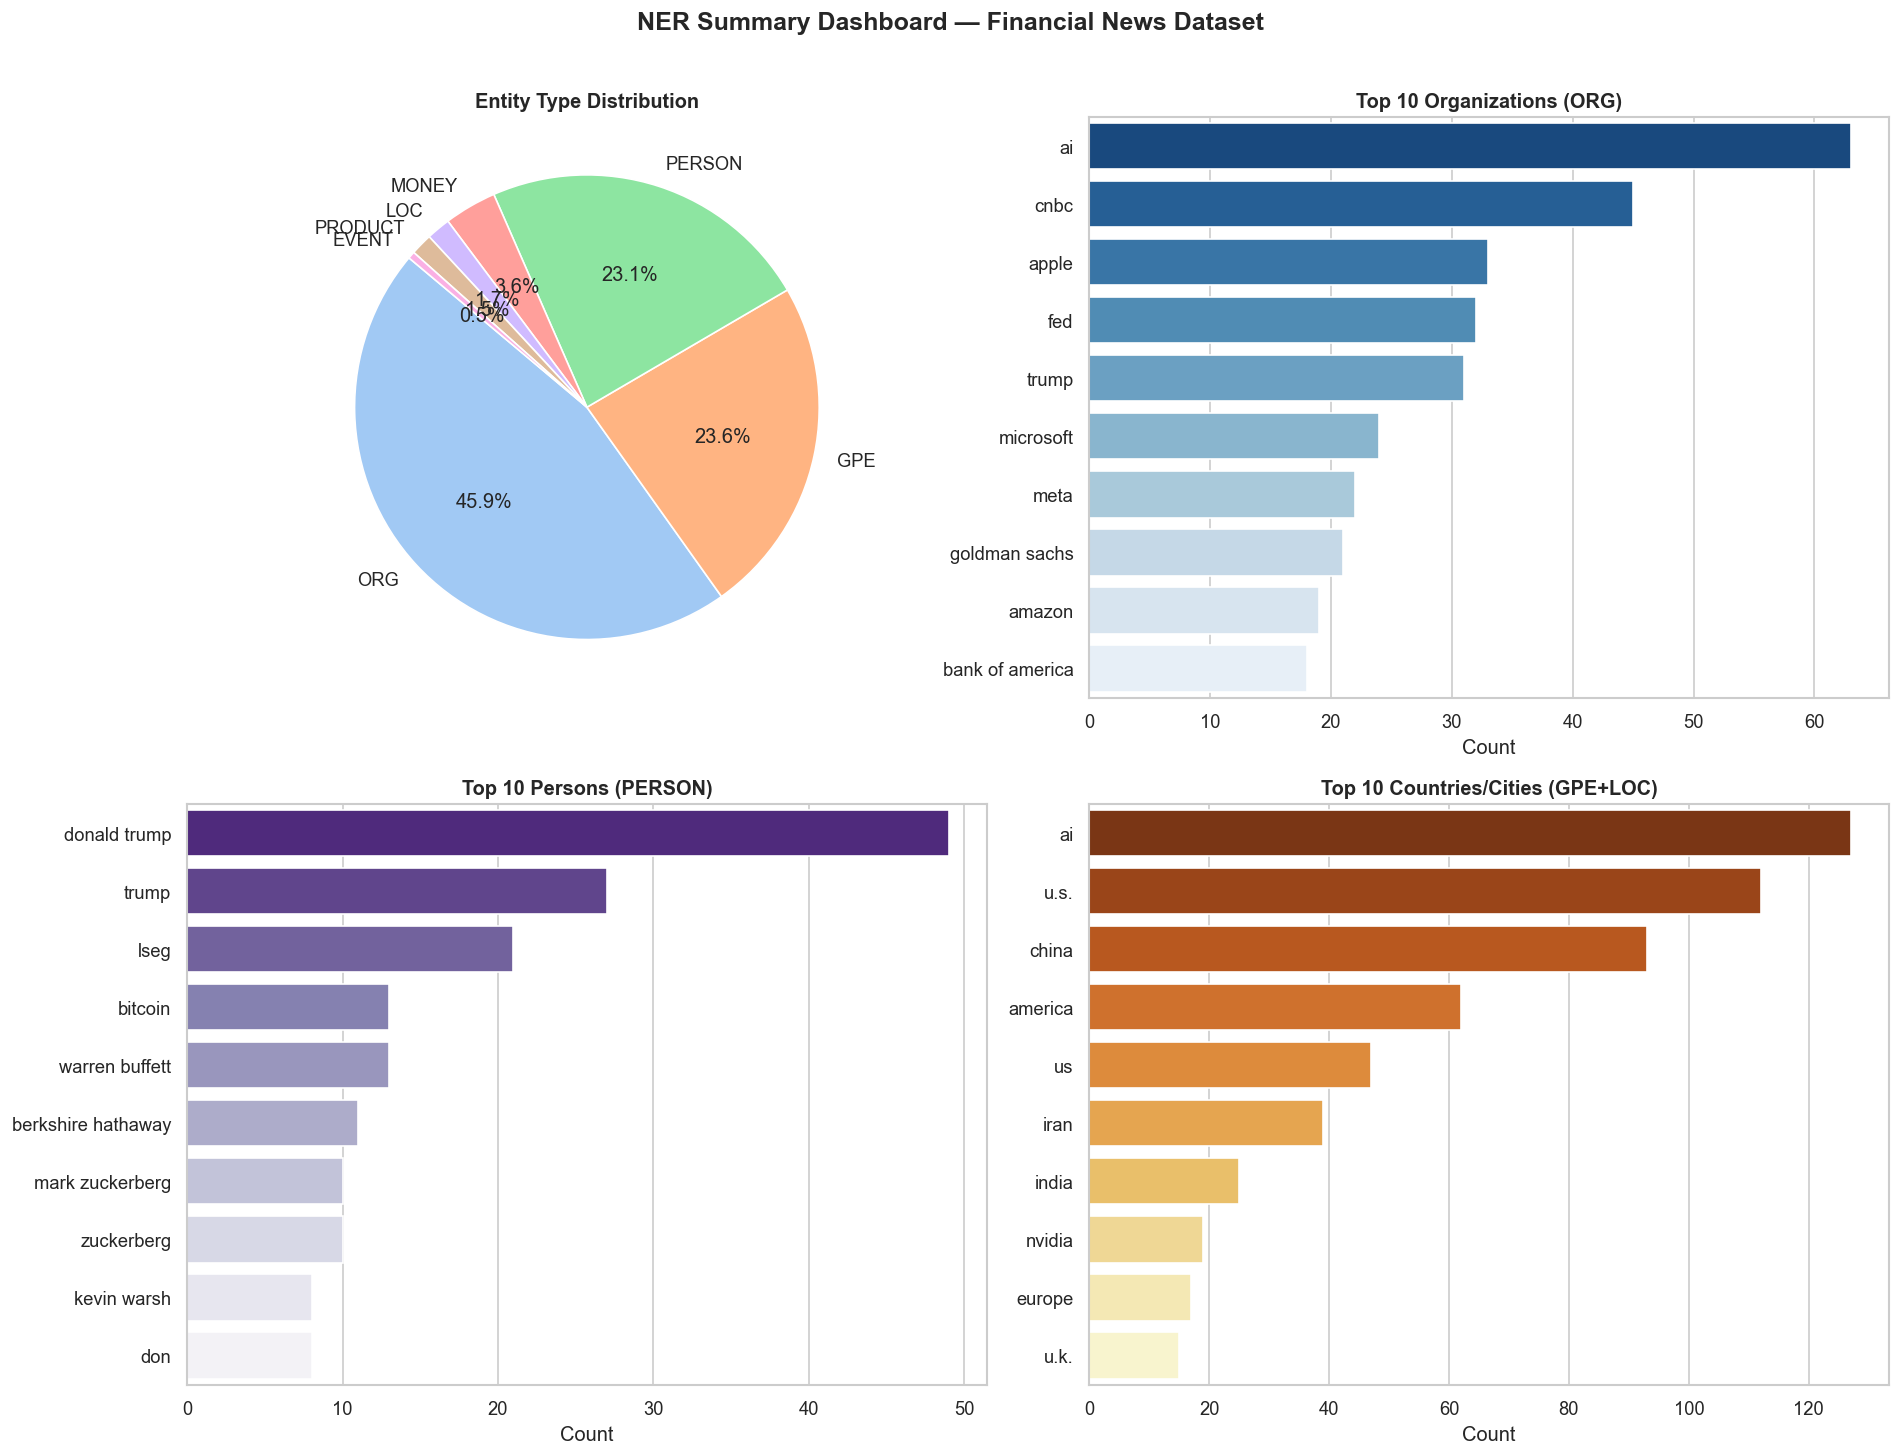

💾 Plot saved: ner_dashboard.png


In [49]:
# Dashboard: Summary of 4 plots on one page
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('NER Summary Dashboard — Financial News Dataset', fontsize=15, fontweight='bold', y=1.01)

# --- Plot 1: Entity Label Distribution (Pie Chart) ---
ax1 = axes[0, 0]
label_counts_plot = ent_df['label'].value_counts()
ax1.pie(
    label_counts_plot.values,
    labels=label_counts_plot.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('pastel')
)
ax1.set_title('Entity Type Distribution', fontweight='bold')

# --- Plot 2: Top 10 ORG ---
ax2 = axes[0, 1]
top10_org = ent_df[ent_df['label'] == 'ORG']['entity'].str.lower().value_counts().head(10)
sns.barplot(x=top10_org.values, y=top10_org.index, ax=ax2, palette='Blues_r')
ax2.set_title('Top 10 Organizations (ORG)', fontweight='bold')
ax2.set_xlabel('Count')
ax2.set_ylabel('')

# --- Plot 3: Top 10 PERSON ---
ax3 = axes[1, 0]
top10_person = ent_df[ent_df['label'] == 'PERSON']['entity'].str.lower().value_counts().head(10)
sns.barplot(x=top10_person.values, y=top10_person.index, ax=ax3, palette='Purples_r')
ax3.set_title('Top 10 Persons (PERSON)', fontweight='bold')
ax3.set_xlabel('Count')
ax3.set_ylabel('')

# --- Plot 4: Top 10 GPE/LOC ---
ax4 = axes[1, 1]
top10_loc = ent_df[ent_df['label'].isin(['GPE', 'LOC'])]['entity'].str.lower().value_counts().head(10)
sns.barplot(x=top10_loc.values, y=top10_loc.index, ax=ax4, palette='YlOrBr_r')
ax4.set_title('Top 10 Countries/Cities (GPE+LOC)', fontweight='bold')
ax4.set_xlabel('Count')
ax4.set_ylabel('')

plt.tight_layout()
plt.savefig('ner_dashboard.png', bbox_inches='tight')
plt.show()
print('💾 Plot saved: ner_dashboard.png')

## 11. ดูตัวอย่าง Entity ที่พบในแต่ละแถว

In [50]:
# ดูตัวอย่างแถวที่มี Entity มากที่สุด
df['entity_count'] = df['entities'].apply(len)
rich_rows = df.nlargest(5, 'entity_count')[['Sentence', 'entities', 'entity_count']]

print('📋 ตัวอย่างประโยคที่มี Entity มากที่สุด:')
print('=' * 60)
for _, row in rich_rows.iterrows():
    print(f'\n[ข้อความ] {row["Sentence"][:120]}...')
    print(f'[จำนวน Entity] {row["entity_count"]} รายการ')
    for ent in row['entities']:
        print(f'  → [{ent["label"]}] {ent["text"]}')
    print('-' * 60)

📋 ตัวอย่างประโยคที่มี Entity มากที่สุด:

[ข้อความ] China's Xi reasserts Taiwan stance in call with Trump, while U.S. president pushes trade. U.S. President Donald Trump sa...
[จำนวน Entity] 28 รายการ
  → [GPE] China
  → [PERSON] Xi
  → [GPE] Taiwan
  → [PERSON] Trump
  → [GPE] U.S.
  → [GPE] U.S.
  → [PERSON] Donald Trump
  → [PERSON] Xi Jinping
  → [GPE] Iran
  → [GPE] Russia
  → [GPE] Ukraine
  → [GPE] China
  → [GPE] Beijing
  → [GPE] Taiwan
  → [GPE] U.S.
  → [GPE] Taiwan
  → [GPE] China
  → [GPE] Taiwan
  → [GPE] Washington
  → [GPE] Taiwan
  → [GPE] Beijing
  → [GPE] China
  → [GPE] Washington
  → [ORG] Trump
  → [GPE] China
  → [PERSON] David Meale
  → [GPE] China
  → [ORG] Eurasia Group
------------------------------------------------------------

[ข้อความ] Trump refuses to be outdone by Europe, signing his own U.S.-India trade deal. U.S. President Donald Trump 's announcemen...
[จำนวน Entity] 25 รายการ
  → [ORG] Trump
  → [LOC] Europe
  → [ORG] U.S.-India
  → [GPE] U.S.
  → [P

## 12. Export ผลลัพธ์ไฟล์ CSV

In [51]:
# Export สรุป Entity ทั้งหมด
ent_summary = ent_df.groupby(['label', 'entity']).size().reset_index(name='count')
ent_summary = ent_summary.sort_values(['label', 'count'], ascending=[True, False])
ent_summary.to_csv('ner_entity_summary.csv', index=False, encoding='utf-8-sig')

print('✅ Export เสร็จแล้ว → ner_entity_summary.csv')
print(f'   จำนวนแถวทั้งหมด: {len(ent_summary):,}')
display(ent_summary.head(10))

✅ Export เสร็จแล้ว → ner_entity_summary.csv
   จำนวนแถวทั้งหมด: 1,818


,label,entity,count
5,EVENT,Lunar New Year,3
8,EVENT,Super Bowl 60,2
13,EVENT,the Lunar New Year,2
0,EVENT,Black Wednesday,1
1,EVENT,Hurricane Melissa,1
2,EVENT,Inflation,1
3,EVENT,Iran Signals Progress in Nuclear Talks,1
4,EVENT,Liberation Day,1
6,EVENT,Olympic,1
7,EVENT,Super Bowl,1


---
## 📌 สรุปผลการวิเคราะห์ NER

**แนวทางการอภิปราย (สำหรับ Report):**

1. **Entity ที่พบมากที่สุดโดยรวม** — ดูจาก Label Distribution ว่าข้อมูล Financial News โดเมนนี้เน้นไปที่ประเภทไหน (น่าจะเป็น ORG และ GPE มากที่สุด)

2. **องค์กรที่โดดเด่น** — บริษัทหรือสถาบันการเงินที่ถูกพูดถึงบ่อยสะท้อน Trend ของตลาดช่วงนั้น

3. **ข้อจำกัดของ Pre-trained Model** — `en_core_web_sm` อาจจำแนก entity ผิดในบางกรณี เช่น ชื่อบริษัทที่เป็นคำทั่วไป (Apple, Amazon) อาจถูกแท็กเป็น PRODUCT แทน ORG ในบางประโยค ซึ่งเป็นประเด็น Error Analysis ที่ดี